In [662]:
import pandas as pd
import urllib3
import re
import json
import numpy as np
import networkx as nx
from melonapi import scrapeMelon
import ast
import os
import spacy
import warnings
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
from bs4 import BeautifulSoup
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from tqdm import tqdm
from wordcloud import WordCloud
from itertools import groupby
from nltk.probability import FreqDist
import translators as ts
ts.google

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/luchengliang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h2>The current top 100 songs on Melon (The top 1 entertainment stream platform in Korea)<h2>

In [22]:
#Used the Melon api tool to search current top 100 songs on Melon platform
rank = scrapeMelon.getList("LIVE").decode()
rank

'{"1": {"name": "사건의 지평선", "artists": "윤하 (YOUNHA)", "ranking": 1, "songId": "34819473", "albumId": "10903868"}, "2": {"name": "ANTIFRAGILE", "artists": "LE SSERAFIM (르세라핌)", "ranking": 2, "songId": "35729104", "albumId": "11078496"}, "3": {"name": "Nxde", "artists": "(여자)아이들", "ranking": 3, "songId": "35730562", "albumId": "11078852"}, "4": {"name": "Hype boy", "artists": "NewJeans", "ranking": 4, "songId": "35454426", "albumId": "11011565"}, "5": {"name": "After LIKE", "artists": "IVE (아이브)", "ranking": 5, "songId": "35546497", "albumId": "11034298"}, "6": {"name": "새삥 (Prod. ZICO) (Feat. 호미들)", "artists": "지코 (ZICO)", "ranking": 6, "songId": "35595136", "albumId": "11045985"}, "7": {"name": "Attention", "artists": "NewJeans", "ranking": 7, "songId": "35454425", "albumId": "11011565"}, "8": {"name": "Rush Hour (Feat. j-hope of BTS)", "artists": "Crush", "ranking": 8, "songId": "35665282", "albumId": "11062364"}, "9": {"name": "Monologue", "artists": "테이", "ranking": 9, "songId": "356

In [23]:
rank_dict = ast.literal_eval(rank) # Make this "string" -> "dict"

Cleaning the data and translate.

In [24]:
rank_en = dict([(key, ts.google(str(value), from_language='ko', to_language='en')) for key, value in rank_dict.items()])
rank_en['44'] = rank_en['44'] + '}'
rank_en['88'] = rank_en['88'] + '}'
rank_en

{'1': "{'Name': 'Horizon of the Incident', 'Artists': 'YOUNHA', 'Ranking': 1, 'Songid': '34819473', 'Albumid': '10903868'}",
 '2': "{'Name': 'AntiFragile', 'Artists': 'Le Sserafim', 'Ranking': 2, 'Songid': '35729104', 'Albumid': '11078496'}",
 '3': "{'Name': 'NXDE', 'Artists': '(Women)', 'Ranking': 3, 'Songid': '35730562', 'Albumid': '11078852'}",
 '4': "{'Name': 'Hype Boy', 'Artists': 'Newjeans', 'Ranking': 4, 'Songid': '35454426', 'Albumid': '11011565'}",
 '5': "{'Name': 'After Like', 'Artists': 'Ive (Ive)', 'Ranking': 5, 'Songid': '35546497', 'Albumid': '11034298'}",
 '6': "{'Name': 'Prod. Zico (Feat. Homi)', 'Artists':' Zico ',' Ranking ': 6,' Songid ':' 35595136 ',' Albumid ':' 11045985 '}",
 '7': "{'Name': 'Attension', 'Artists': 'Newjeans', 'Ranking': 7, 'Songid': '35454425', 'Albumid': '11011565'}",
 '8': "{'Name': 'Rush Hour (Feat. J-Hope of BTS)', 'Artists': 'Crush', 'Ranking': 8, 'Songid': '35665282', 'Albumid': '11062364'}",
 '9': "{'Name': 'Monologue', 'Artists': 'Tei', 'R

<h1>Build the dataset<h1>

In [86]:
from pathlib import Path
mother_dir = Path("Rank_eachArtist")

In [676]:
#The groups we interested in (Which are in TOP 100 in Melon)
group_name = []
for name in list(mother_dir.glob("*.csv")):
    name = str(name)
    name = name.replace("Rank_eachArtist/", "")
    name = name.replace(".csv", "")
    group_name.append(name)
print(group_name)

['Aespa', 'Girls-Generation', 'BTS', 'ITZY', '(G)-IDLE', 'Red_Velvet', 'IU', 'Twice', 'Ive', 'Le_Sserafim', 'BLACKPINK', 'Bigbang', 'NewJeans', 'NMIXX']


<h4>Build the each group's dataframe<h4>

In [88]:
#Each groups' dataframe
Le_Sserafim_df = Le_Sserafim_df = pd.read_csv("Rank_eachArtist/" + "Le_Sserafim" + ".csv")
if 'Unnamed: 0' in Le_Sserafim_df:
    Le_Sserafim_df.drop(['Unnamed: 0'], axis=1, inplace=True)
Le_Sserafim_df['group'] = 'Le_Sserafim'
Le_Sserafim_df['group_wiki'] = 'le-sserafim'
    
Girls_Generation_df = pd.read_csv("Rank_eachArtist/" + "Girls-Generation" + ".csv")
if 'Unnamed: 0' in Girls_Generation_df:
    Girls_Generation_df.drop(['Unnamed: 0'], axis=1, inplace=True)
Girls_Generation_df['group'] = 'Girls-Generation' 
Girls_Generation_df['group_wiki'] = 'girls-generation'
    
BTS_df = pd.read_csv("Rank_eachArtist/" + "BTS" + ".csv")
if 'Unnamed: 0' in BTS_df:
    BTS_df.drop(['Unnamed: 0'], axis=1, inplace=True)
BTS_df['group'] = 'BTS'
BTS_df['group_wiki'] = 'bts'
    
ITZY_df = pd.read_csv("Rank_eachArtist/" + "ITZY" + ".csv")
if 'Unnamed: 0' in ITZY_df:
    ITZY_df.drop(['Unnamed: 0'], axis=1, inplace=True)
ITZY_df['group'] = 'ITZY'
ITZY_df['group_wiki'] = 'itzy'
    
G_IDLE_df = pd.read_csv("Rank_eachArtist/" + "(G)-IDLE" + ".csv")
if 'Unnamed: 0' in G_IDLE_df:
    G_IDLE_df.drop(['Unnamed: 0'], axis=1, inplace=True)
G_IDLE_df['group'] = '(G)-IDLE'
G_IDLE_df['group_wiki'] = 'g-i-dle'
    
Red_Velvet_df = pd.read_csv("Rank_eachArtist/" + "Red_Velvet" + ".csv")
if 'Unnamed: 0' in Red_Velvet_df:
    Red_Velvet_df.drop(['Unnamed: 0'], axis=1, inplace=True)
Red_Velvet_df['group_wiki'] = 'Red_Velvet'
Red_Velvet_df['group_wiki'] = 'redvelvet'
    
IU_df = pd.read_csv("Rank_eachArtist/" + "IU" + ".csv")
if 'Unnamed: 0' in IU_df:
    IU_df.drop(['Unnamed: 0'], axis=1, inplace=True)
IU_df['group'] = 'IU'
IU_df['group_wiki'] = 'i-u'
    
Twice_df = pd.read_csv("Rank_eachArtist/" + "Twice" + ".csv")
if 'Unnamed: 0' in Twice_df:
    Twice_df.drop(['Unnamed: 0'], axis=1, inplace=True)
Twice_df['group'] = 'Twice'
Twice_df['group_wiki'] = 'twice'
    
Aespa_df = pd.read_csv("Rank_eachArtist/" + "Aespa" + ".csv")
if 'Unnamed: 0' in Aespa_df:
    Aespa_df.drop(['Unnamed: 0'], axis=1, inplace=True)
Aespa_df['group'] = 'Aespa'
Aespa_df['group_wiki'] = 'aespa'
    
Ive_df = pd.read_csv("Rank_eachArtist/" + "Ive" + ".csv")
if 'Unnamed: 0' in Ive_df:
    Ive_df.drop(['Unnamed: 0'], axis=1, inplace=True)
Ive_df['group'] = 'Ive'
Ive_df['group_wiki'] = 'ive'
    
BLACKPINK_df = pd.read_csv("Rank_eachArtist/" + "BLACKPINK" + ".csv")
if 'Unnamed: 0' in BLACKPINK_df:
    BLACKPINK_df.drop(['Unnamed: 0'], axis=1, inplace=True)
BLACKPINK_df['group'] = 'BLACKPINK'
BLACKPINK_df['group_wiki'] = 'black-pink'
    
Bigbang_df = pd.read_csv("Rank_eachArtist/" + "Bigbang" + ".csv")
if 'Unnamed: 0' in Bigbang_df:
    Bigbang_df.drop(['Unnamed: 0'], axis=1, inplace=True)
Bigbang_df['group'] = 'Bigbang'
Bigbang_df['group_wiki'] = 'bigbangkpop'
    
NewJeans_df = pd.read_csv("Rank_eachArtist/" + "NewJeans" + ".csv")
if 'Unnamed: 0' in NewJeans_df:
    NewJeans_df.drop(['Unnamed: 0'], axis=1, inplace=True)
NewJeans_df['group'] = 'NewJeans'
NewJeans_df['group_wiki'] = 'newjeans'
    
NMIXX_df = pd.read_csv("Rank_eachArtist/" + "NMIXX" + ".csv")
if 'Unnamed: 0' in NMIXX_df:
    NMIXX_df.drop(['Unnamed: 0'], axis=1, inplace=True)
NMIXX_df['group'] = 'NMIXX'
NMIXX_df['group_wiki'] = 'nmixx'

**The combination of dataframes**

In [89]:
#Combine all the dataframes
frames = [Le_Sserafim_df, Girls_Generation_df, BTS_df, ITZY_df, 
          G_IDLE_df, Red_Velvet_df, IU_df, Twice_df, Aespa_df,
          Ive_df, BLACKPINK_df, Bigbang_df, NewJeans_df, NMIXX_df]

all_df = pd.concat(frames)
all_df.fillna(0)
#all_df.song.combine_first(all_df.Song)
#all_df.resource.combine_first(all_df.Resourse)
#all_df.drop(['Song', 'Resourse'], axis=1, inplace=True)
all_df.reset_index(inplace=True)
all_df.drop(['index'], axis=1, inplace=True)
all_df

,NO,song,resource,Web,group,group_wiki
0,1,ANTIFRAGILE_(song),Wiki_f,https://le-sserafim.fandom.com/wiki/ANTIFRAGIL...,Le_Sserafim,le-sserafim
1,2,Fearless_(Le_Sserafim_song),Wiki,NaN,Le_Sserafim,le-sserafim
2,3,impurities,NaN,NaN,Le_Sserafim,le-sserafim
3,4,Good Parts (when the quality is bad but I am),NaN,NaN,Le_Sserafim,le-sserafim
4,5,no celestial,NaN,NaN,Le_Sserafim,le-sserafim
...,...,...,...,...,...,...
203,3,Funky_Glitter_Christmas,Wiki_f,https://kpop.fandom.com/wiki/Funky_Glitter_Chr...,NMIXX,nmixx
204,4,COOL_(Your_rainbow),Wiki_f,https://nmixx.fandom.com/wiki/COOL_(Your_rainbow),NMIXX,nmixx
205,5,Kiss,Wiki_f,https://nmixx.fandom.com/wiki/Kiss,NMIXX,nmixx
206,6,TANK,Wiki_f,https://nmixx.fandom.com/wiki/TANK,NMIXX,nmixx


<h2>Wikipage Scraping(Wiki pages, Kpop fandom wiki pages, and Kpop fandom their own wiki pages)<h2>

**Scrape our data from the three kind of websites(Wiki, Wiki kpop fandom, and Wiki kpop fandom for each group)**

In [2]:
http = urllib3.PoolManager()
baseurl = "https://" + "aespa" + ".fandom.com/api.php?"
action = "action=query"
title = "titles=" + "Illusion#Lyrics"
content = "prop=revisions&rvprop=content"
dataformat = "format=json"

query = "%s%s&%s&%s&%s" % (baseurl, action, content, title, dataformat)
query

'https://aespa.fandom.com/api.php?action=query&prop=revisions&rvprop=content&titles=Illusion#Lyrics&format=json'

In [102]:
http = urllib3.PoolManager()

#Different kind of wiki websites that we can scrape

def wiki_scr(text):
   baseurl = "https://en.wikipedia.org/w/api.php?"
   action = "action=query"
   title = "titles=" + text
   content = "prop=revisions&rvprop=content"
   dataformat = "format=json"
   
   query = "%s%s&%s&%s&%s" % (baseurl, action, content, title, dataformat)
   wiki_bf(text, query)

def wiki_kpop_scr(text):
   baseurl = "https://kpop.fandom.com/api.php?"
   action = "action=query"
   title = "titles=" + text
   content = "prop=revisions&rvprop=content"
   dataformat = "format=json"

   query = "%s%s&%s&%s&%s" % (baseurl, action, content, title, dataformat)
   wiki_bf(text, query)
   

def wiki_scr_kpopEach(gname, text):
   baseurl = "https://" + gname + ".fandom.com/api.php?"
   action = "action=query"
   title = "titles=" + text
   content = "prop=revisions&rvprop=content"
   dataformat = "format=json"

   query = "%s%s&%s&%s&%s" % (baseurl, action, content, title, dataformat)
   wiki_bf(text, query)
   

def wiki_bf(text, query):
   wikiresource = http.request('GET', query)
   wikijson = json.loads(wikiresource.data.decode('utf-8'))
   
   if re.search(r'/', text):
      text = text.replace("/", "\\")
    
   with open('/Users/luchengliang/Social_Graph_and_Networks/Final_Project/jsonWebpage/' + text + '.txt', 'w') as f:
      f.write(str(wikijson))

In [101]:
for i in range(len(all_df)):
   x = all_df.iloc[i, :]
   
   #Scrape different kind of wiki pages
   #First is the normal wiki
   if x['resource'] == 'Wiki':
      q = wiki_scr(x['song'])

   if x['resource'] == 'Wiki_f':
      #Second one is from Kpop fandom page, not their own page
      if '//kpop.fandom' in str(x['Web']):
         q = wiki_kpop_scr(x['song'])
      elif type(x['group_wiki']) != float:
         #Third one is from each fandom wiki page
         q = wiki_scr_kpopEach(x['group_wiki'], x['song'])
      else:
         continue

**The json files we have scraped from the wiki pages' content in our local computer**

In [104]:
path = "/Users/luchengliang/Social_Graph_and_Networks/Final_Project/jsonWebpage"

dir_list = os.listdir(path)

print("Files: ") 
# print the list
print(dir_list)

Files: 
['Typa_Girl.txt', 'Change.txt', 'Tell_Me_Your_Wish_(Genie)_(song).txt', 'Never_Stop_Me.txt', 'Black_Swan.txt', 'Happiness.txt', 'Butter_(song).txt', 'Bang_Bang_Bang.txt', 'Dance_The_Night_Away.txt', 'Hurt.txt', 'SNEAKERS.txt', 'Lovesick_Girls.txt', 'Talk_That_Talk.txt', 'The_Truth_Untold.txt', 'Cookie.txt', 'Hype_Boy.txt', 'Oh!_(song).txt', 'Blue.txt', 'I_Need_U_(BTS_song).txt', 'In_the_morning.txt', 'Merry_%26_Happy.txt', 'After_LIKE.txt', '.DS_Store', 'Christmas_Carol_Medley.txt', 'Butterfly.txt', 'Wish_Tree.txt', 'Magic_Shop.txt', 'Not_Shy.txt', 'Like.txt', 'Twenty.txt', 'ICY.txt', 'Sour_Grapes.txt', 'Illusion.txt', 'Boy_with_Luv.txt', 'Answer:_Love_Myself.txt', 'Fantastic_Baby.txt', 'Yes_Or_Yes.txt', 'Nxde.txt', 'Anpanman.txt', 'Ice_Cream_Cake_(song).txt', 'Take_It.txt', 'Stay.txt', 'LOCO.txt', 'Dreams_Come_True.txt', 'Left_and_Right_(Feat._Jung_Kook_of_BTS).txt', 'Palette.txt', 'HWAA.txt', 'Epiphany.txt', 'Don%27t_Know_What_To_Do.txt', 'Heart_Shaker.txt', 'Luv_U.txt', 'Psy

<h1>Find Lyrics<h1>

In [675]:
#Add lyrics column for our lyrics from each song.
all_df['lyrics'] = pd.Series(dtype='str')

**The process for finding lyrics in json webpage text storing in the local folder or on their own wiki page**

In [550]:
def kpop_eachfandom_lyrics(text, gname):
    if text == "POP/STARS":
        connections = CoolWayFindLyrics(text, gname)
    else:
        with open("./jsonWebpage/" + text + ".txt") as f:
            Aes = f.readlines()
            try:
                connections = re.findall(r'\|English = \\\\n<poem>(.*)\\\\n<\/poem>', str(Aes))
                connections = connections[0]
            except IndexError:
                try:
                    connections = re.findall(r'\|English=<poem>(.*)\\\\n<\/poem>', str(Aes))
                    connections = connections[0]
                except IndexError:
                    try:
                        connections = re.findall(r'English=\\\\n<poem>\\\\n(.*)\\\\n<\/poem>', str(Aes))
                        connections = connections[0]
                    except IndexError:
                        try:
                            connections = re.findall(r'English=\\\\n<poem>(.*)\\\\n<\/poem>', str(Aes))
                            connections = connections[0]
                        except IndexError:
                            try:
                                connections = re.findall(r'English=<poem>(.*)<\/poem>', str(Aes))
                                connections = connections[0]
                            except IndexError:
                                try:
                                    connections = re.findall(r'English\]\]\)\\\\n\|lyrics =<poem>(.*)<\/poem>', str(Aes))
                                    connections = connections[0]
                                except IndexError:
                                    try:
                                        connections = re.findall(r'English=\\\\n<poem>\\\\n(.*)<\/poem>', str(Aes))
                                        connections = connections[0]
                                    except IndexError:
                                        try:
                                            connections = re.findall(r'English=\\\\n<poem>(.*)<\/poem>', str(Aes))
                                            connections = connections[0]
                                        except IndexError:
                                            try:
                                                connections = re.findall(r'Translation=\\\\n<poem>\\\\n(.*)\\\\n<\/poem>', str(Aes))
                                                connections = connections[0]
                                            except IndexError:
                                                connections = annother(str(Aes))
                                                
            connections = connections.replace("\\\\n", ". ")
            connections = ''.join(char for char in connections if char.isalnum() or char.isspace())
            connections = connections.replace("ColorKarina", "")
            connections = connections.replace("ColorNingning", "")
            connections = connections.replace("ColorWinter", "")
            connections = connections.replace("ColorGiselle", "")
            connections = connections.replace("  ", " ")
            connections = connections.replace("   ", " ")
            
            # Remove annoying things
            #tokens = word_tokenize(connections.lower())
            #english_stopwords = stopwords.words('english')
            #tokens_wo_stopwords= [t for t in tokens if t not in english_stopwords]
            #connections = " ".join(tokens_wo_stopwords)
            connections = connections.lower()
            
            if connections == "nfind":
                connections = CoolWayFindLyrics(text, gname)
            
            connections = ' '.join(word for word in connections.split(' ') if not word.startswith(('color', 'lyrics')))
            
        
    return connections
        
def annother(t):
    try:
        connections = re.findall(r'Lyrics\\\\n\|content=\\\\n<poem>\\\\n(.*)\\\\n<\/poem>', t)
        connections = connections[0]
    except IndexError:
        try:
            connections = re.findall(r'eng=\\\\n<poem>\\\\n(.*)\\\\n<\/poem>', t)
            connections = connections[0]
        except IndexError:
            connections = "n_find"
    return connections
        
def CoolWayFindLyrics(song_name, gname):
    url = "https://" + gname + ".fandom.com/wiki/" + song_name
    req = urllib3.PoolManager()
    res = req.request('GET', url)
    soup = BeautifulSoup(res.data, 'html.parser')
    lyrics = soup.find_all('div', attrs={"class":"poem"})
    if len(lyrics) == 0:
        return "nfind"
    
    #Become the normal lyrics
    try:
        result = re.sub(r'\<(.*)\>', '', lyrics[-2].prettify())
    except IndexError:
        result = re.sub(r'\<(.*)\>', '', lyrics[-1].prettify())
    
    result = re.sub(r'\n', '', result)
    result = ' '.join(result.split())

    #Replace annoying words
    #tokens = word_tokenize(result.lower())
    #english_stopwords = stopwords.words('english')
    #tokens_wo_stopwords= [t for t in tokens if t not in english_stopwords]
    #result = " ".join(tokens_wo_stopwords)
    result = result.lower()
    result = ''.join(char for char in result if char.isalnum() or char.isspace())
    result = ' '.join(result.split())
    return result

In [551]:
for i in tqdm(range(len(all_df))):
    x = all_df.iloc[i, :]

    if x['resource'] == 'Wiki_f':
        if '//kpop.fandom' not in str(x['Web']):
            #print(x['song'])
            lyrics = kpop_eachfandom_lyrics(x['song'], x['group_wiki'])
            all_df.loc[i, ['lyrics']] = lyrics
        else:
            continue

100%|██████████| 208/208 [00:55<00:00,  3.75it/s]


<h2>The Songs that have lyrics<h2>

<h3>Original ver. without cleaning<h3>

In [554]:
#Get rid of the songs that cannot find lyrics in the json webpage files or on their kpop wiki fandom.
df_wLyrics = all_df[(all_df['lyrics'] != 'nfind') & (all_df['lyrics'].isna() == False)] 
df_wLyrics = df_wLyrics.reset_index()
del df_wLyrics['index']

df_wLyrics

,NO,song,resource,Web,group,group_wiki,lyrics
0,1,ANTIFRAGILE_(song),Wiki_f,https://le-sserafim.fandom.com/wiki/ANTIFRAGIL...,Le_Sserafim,le-sserafim,anti ti ti ti fragile fragile anti ti ti ti f...
1,6,Blue_Flame,Wiki_f,NaN,Le_Sserafim,le-sserafim,like it ill like it like that feeling somethi...
2,7,Sour_Grapes,Wiki_f,NaN,Le_Sserafim,le-sserafim,ru ru ru ru du du yeah i dont know either its...
3,9,The_Great_Mermaid,Wiki_f,NaN,Le_Sserafim,le-sserafim,never cost no matter what you wont give up on...
4,1,Forever_1_(song),Wiki_f,https://girls-generation.fandom.com/wiki/Forev...,Girls-Generation,girls-generation,forever 1 love its love not stopping by being ...
...,...,...,...,...,...,...,...
155,2,O.O,Wiki_f,https://nmixx.fandom.com/wiki/O.O,NMIXX,nmixx,whook whook ay look at that moving eye eyes se...
156,4,COOL_(Your_rainbow),Wiki_f,https://nmixx.fandom.com/wiki/COOL_(Your_rainbow),NMIXX,nmixx,a long night repeated bad dreams cover the wor...
157,5,Kiss,Wiki_f,https://nmixx.fandom.com/wiki/Kiss,NMIXX,nmixx,everyday remonticheoreom dalkomhan ipsul ojik ...
158,6,TANK,Wiki_f,https://nmixx.fandom.com/wiki/TANK,NMIXX,nmixx,who dat veil that is finally slipping down tha...


<h3>Fixing the lyrics(Please, don't run again beneath parts until seen the "end" part)<h3>

**Manual modify the lyrics part**

In [556]:
df_wLyrics.drop(labels=[44, 27, 62, 72, 74, 76, 77, 78, 79, 114, 150, 151, 152, 153], axis=0, inplace=True)
df_wLyrics.drop(['Web', 'resource', 'group_wiki'], axis=1, inplace=True)

In [557]:
df_wLyrics.loc[75:94, ['group']] = "Red Velvet"

In [502]:
with open('missing.rtf', 'r') as file:
    text = file.read()
#Replace Stop words
result = text
result = ' '.join(word for word in result.split(' ') if not word.startswith('\\'))
#tokens = word_tokenize(result.lower())
#english_stopwords = stopwords.words('english')
#tokens_wo_stopwords= [t for t in tokens if t not in english_stopwords]
#result = " ".join(tokens_wo_stopwords)
result = result.lower()
result = ''.join(char for char in result if char.isalnum() or char.isspace())
result = ' '.join(result.split())

df_wLyrics.loc[157, ['lyrics']] = result

'''
with open('readme.txt', 'w') as f:
    f.write(result)
'''

"\nwith open('readme.txt', 'w') as f:\n    f.write(result)\n"

In [558]:
outputpath = 'Melon_Songs_wStop.csv'
df_wLyrics.to_csv(outputpath, sep=',', index=True, header=True)

In [674]:
MelonSongs_df = pd.read_csv('Melon_Songs_wStop_final.csv', index_col=0)
MelonSongs_df = MelonSongs_df.reset_index()
MelonSongs_df.drop(['index'], axis=1, inplace=True)
#MelonSongs_df.drop([29], axis=0, inplace=True)
MelonSongs_df = MelonSongs_df.reset_index()

for i in range(len(MelonSongs_df)):
    text = MelonSongs_df.loc[i, ['song']].item()
    text2 = MelonSongs_df.loc[i, ['group']].item()
    
    #let the punctuation com back on our groups' names and songs' names
    text = text.replace("_", " ")
    text = text.replace("%27","'")
    text = text.replace("%26", "&")
    text2 = text2.replace("_", " ")
    
    MelonSongs_df.loc[i, ['song']] = text
    MelonSongs_df.loc[i, ['group']] = text2


In [577]:
outputpath = 'MS_wStop.csv'
MelonSongs_df.to_csv(outputpath, sep=',', index=True, header=True)

In [581]:
MelonSongs_df = pd.read_csv('MS_wStop_needmodify.csv', index_col=0)

#In the BTS's songs, they have added the singers who belongs to what part inside the lyrics, 
# so we needed to remove them by manual way
for i in range(len(MelonSongs_df)):
    text = MelonSongs_df.loc[i, ['lyrics']].item()
    text = text.replace("jimin and v", "")
    text = text.replace("jimin and jungkook", "")
    text = text.replace("jimin and rm", "")
    text = text.replace("jimin and sugar", "")
    text = text.replace("jimin and jin", "")
    
    text = text.replace("v and jimin", "")
    text = text.replace("v and jin", "")
    text = text.replace("v and rm", "")
    text = text.replace("v and sugar", "")
    text = text.replace("v and junkook", "")
    
    text = text.replace("jin and jimin", "")
    text = text.replace("jin and rm", "")
    text = text.replace("jin and sugar", "")
    text = text.replace("jin and jungkook", "")
    text = text.replace("jin and v", "")
    
    text = text.replace("junkook and sugar", "")
    text = text.replace("junkook and jimin", "")
    text = text.replace("junkook and rm", "")
    text = text.replace("junkook and v", "")
    text = text.replace("junkook and jin", "")
    
    text = text.replace("sugar and rm", "")
    text = text.replace("sugar and jimin", "")
    text = text.replace("sugar and jungkook", "")
    text = text.replace("sugar and v", "")
    text = text.replace("sugar and jin", "")
    
    text = text.replace("v", "")
    text = text.replace("jungkook", "")
    text = text.replace("jimin", "")
    text = text.replace("rm", "")
    text = text.replace("suga", "")
    text = text.replace("jin", "")
    text = text.replace("jhope", "")
    
    MelonSongs_df.loc[i, ['lyrics']] = text

#output our new csv dataframe file but still it needed to be modified
outputpath = 'MS_modified.csv'
MelonSongs_df.to_csv(outputpath, sep=',', index=True, header=True)

In [651]:
#Load the csv through manual modified
MelonSongs_df = pd.read_csv('MS_final.csv', index_col=0)
MelonSongs_df.drop(['index'], axis=1, inplace=True)
MelonSongs_df.loc[53:68, ['group']] = "(G)I-DLE"

#output the cleanest verion of our dataframe
outputpath = 'MS_final.csv'
MelonSongs_df.to_csv(outputpath, sep=',', index=True, header=True)

<h3>Fixing the lyrics end(Please, don't touch the thing above)<h3>

<h3>The correct dataframe after fixing<h3>

In [653]:
#Check the complete dataframe we have. (Delete the song with empty or without english lyrics in the lyrics' field.)
MelonSongs_df = pd.read_csv('MS_final.csv', index_col=0)
MelonSongs_df

,NO,song,group,lyrics
0,1,ANTIFRAGILE (song),Le Sserafim,anti ti ti ti fragile fragile anti ti ti ti f...
1,6,Blue Flame,Le Sserafim,like it ill like it like that feeling somethin...
2,7,Sour Grapes,Le Sserafim,ru ru ru ru du du yeah i dont know either its ...
3,9,The Great Mermaid,Le Sserafim,neer cost no matter what you wont gie up one ...
4,1,Forever 1 (song),Girls-Generation,foreer 1 loe its loe not stopping by being in ...
...,...,...,...,...
140,2,O.O,NMIXX,whook whook ay look at that moing eye eyes see...
141,4,COOL_(Your_rainbow),NMIXX,a long night repeated bad dreams coer the worl...
142,5,Kiss,NMIXX,lips sweet like lemon tea gift without anyone ...
143,6,TANK,NMIXX,who dat eil that is finally slipping down than...


<h2>WorldCloud for all<h2>

**We will analyze the frequency of different words in the lyrics in the national song’s part by wordcloud.**

In [655]:
MelonAllLyrics = ""
for i in range(len(MelonSongs_df)):
    MelonAllLyrics += MelonSongs_df.loc[i , ['lyrics']].item() + " "

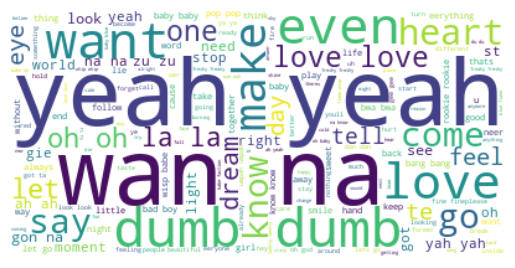

In [658]:
def wordCloud(text):
    #Make text without the stopwords
    tokens = word_tokenize(text)
    english_stopwords = stopwords.words('english')
    tokens_wo_stopwords= [t for t in tokens if t not in english_stopwords]
    words = " ".join(tokens_wo_stopwords)
    #Data cleaning for the lyrics from wiki kpop fanpage since they have added data encryption in lyroics part
    words = words.replace("im", "")
    words = words.replace("dont", "")
    words = words.replace("ill", "")
    words = words.replace("cant", "")
    words = words.replace("youre", "")
    words = words.replace("loe", "love")
    words = words.replace("hae", "have")
    words = words.replace("een", "even")
    words = words.replace("saage", "savage")
    return words

words = wordCloud(MelonAllLyrics)
# lower max_font_size
wordcloud = WordCloud(background_color='white', max_font_size=80).generate(words)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**We will analyze the frequency of different words in the lyrics from each group respectively by wordcloud.**

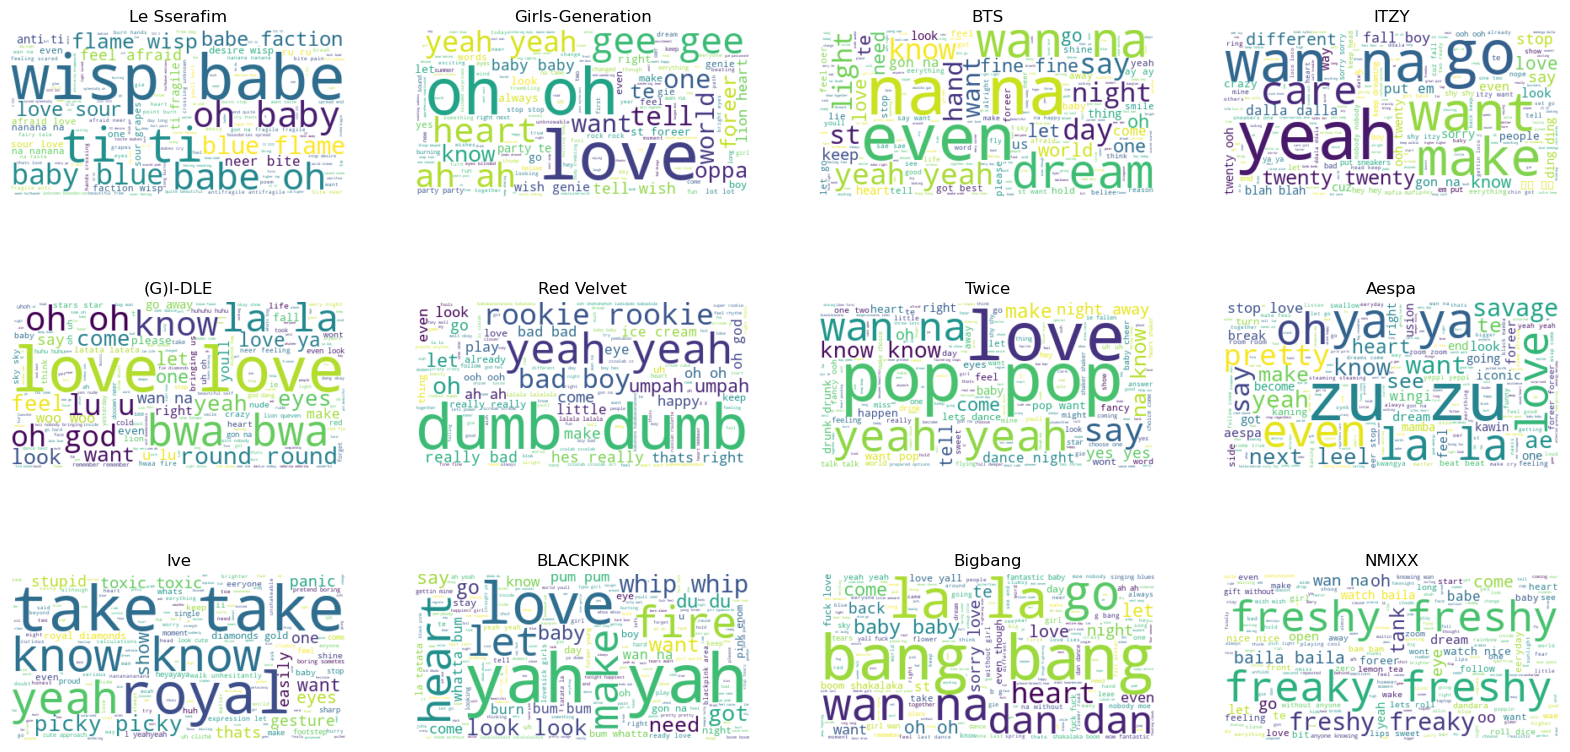

In [657]:
wordcloud = []
last_group = ""
list_of_group = MelonSongs_df['group'].tolist()
list_of_group = [k for k,_ in groupby(list_of_group)]

for i in range(len(MelonSongs_df)):
    group = MelonSongs_df.loc[i, ['group']].item()
    
    if i != (len(MelonSongs_df) - 1):
        future_group = MelonSongs_df.loc[i+1, ['group']].item()
        #The last song of the group in the list, so put the text into wordcloud to analyze
        if group != future_group:
            text += (" " + MelonSongs_df.loc[i, ['lyrics']].item()) 
            words = wordCloud(text)
            wordcloud.append(WordCloud(background_color='white', max_font_size=80).generate(words))
            last_group = group
        #The new group needs to create a new string for their text in wordcloud
        elif group != last_group:
            text = ""
            text += (" " + MelonSongs_df.loc[i, ['lyrics']].item())
            last_group = group   
        #Continue input the words inside their string
        else:
            text += (" " + MelonSongs_df.loc[i, ['lyrics']].item())
            last_group = group
    else:
        words = wordCloud(text)
        wordcloud.append(WordCloud(background_color='white', max_font_size=80).generate(words))
        last_group = group

#Test the length of list wordcloud should be the same as list of groups
assert len(wordcloud) == len(list_of_group)

fig = plt.figure(figsize=(20, 10))
rows = 3
columns = 4

for i in range(len(list_of_group)):
    # Adds a subplot at the positions
    fig.add_subplot(rows, columns, i+1)
    
    # showing image
    plt.imshow(wordcloud[i], interpolation="bilinear")
    plt.axis('off')
    plt.title(list_of_group[i])
  

plt.show()

<h1>Sentiment Score<h1>

<h3>Load the field of score field<h3>

In [632]:
# get the data set from source
sen = 'https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0026752.s001'
df_sen = pd.read_csv(sen, sep='\t', header = 2, 
                        usecols=['word', 'happiness_average'],
                        engine='python')
df_sen

,word,happiness_average
0,laughter,8.50
1,happiness,8.44
2,love,8.42
3,happy,8.30
4,laughed,8.26
...,...,...
10217,murder,1.48
10218,terrorism,1.48
10219,rape,1.44
10220,suicide,1.30


In [633]:
# clear up function for the content
# returns only tokens NOT in stopwords
def clear_up(content):
    try:
        tokenizer = nltk.RegexpTokenizer(r'\w+')
        wordsOnly = tokenizer.tokenize(content)
        tokens    = [w for w in wordsOnly if not w.lower() 
                        in stopwords.words('english')]
    except:
        tokens    = []
    return tokens

# shorten fucntion for lemamation
# can only handle one word at a time
# it will "purify" the tokens
lemmatizer = nltk.wordnet.WordNetLemmatizer()
lemma      = lemmatizer.lemmatize

**Data cleaning for the lyrics from wiki kpop fanpage since they have added data encryption in lyroics part**

In [659]:
for i in range(len(MelonSongs_df)):
    text = MelonSongs_df.loc[i, ['lyrics']].item()
    words = text.replace("im", "")
    words = words.replace("dont", "")
    words = words.replace("ill", "")
    words = words.replace("cant", "")
    words = words.replace("youre", "")
    words = words.replace("loe", "love")
    words = words.replace("hae", "have")
    words = words.replace("een", "even")
    words = words.replace("saage", "savage")
    words = words.replace("foreer", "forever")
    MelonSongs_df.loc[i, ['lyrics']] = words
MelonSongs_df

,NO,song,group,lyrics
0,1,ANTIFRAGILE (song),Le Sserafim,anti ti ti ti fragile fragile anti ti ti ti f...
1,6,Blue Flame,Le Sserafim,like it like it like that feeling something l...
2,7,Sour Grapes,Le Sserafim,ru ru ru ru du du yeah i know either its swee...
3,9,The Great Mermaid,Le Sserafim,neer cost no matter what you wont gie up one ...
4,1,Forever 1 (song),Girls-Generation,forever 1 love its love not stopping by being ...
...,...,...,...,...
140,2,O.O,NMIXX,whook whook ay look at that moing eye eyes see...
141,4,COOL_(Your_rainbow),NMIXX,a long night repeated bad dreams coer the worl...
142,5,Kiss,NMIXX,lips sweet like lemon tea gift without anyone ...
143,6,TANK,NMIXX,who dat eil that is finally slipping down than...


In [660]:
# adding clear tokens
# this would take long
MelonSongs_df['Tokens'] = MelonSongs_df.lyrics.apply(clear_up) 
MelonSongs_df['Tokens'] = MelonSongs_df.Tokens.apply(lambda x: [lemma(i) for i in x])

In [661]:
# a dict for the sentiment score 
# every item in form of k,v: (word, score) 
senDict = {df_sen.at[i,'word']: float(df_sen.at[i,'happiness_average']) 
                for i in range(df_sen.shape[0])}

In [663]:
# keep only the tokens with score
# and have frequences of them
MelonSongs_df['Tokens'] = MelonSongs_df.Tokens.apply(lambda x: list(set(x) &
                                        set(senDict.keys())))
MelonSongs_df['tf']     = MelonSongs_df.Tokens.apply(FreqDist)

In [665]:
# mark the length of tf list for later calculation
# have sentiment set with both values and tokens
# recalculate the sentiment after total score is in
MelonSongs_df['numOftf']   = MelonSongs_df.tf.apply(len)
MelonSongs_df['Sentiment'] = MelonSongs_df.tf.apply(lambda x:
                                        {k: senDict[k]*v for k,v in x.items()})
MelonSongs_df['totalSentiment'] = MelonSongs_df.Sentiment.apply(lambda x: sum(x.values()))
MelonSongs_df['Sentiment']      = MelonSongs_df['totalSentiment']/MelonSongs_df['numOftf']

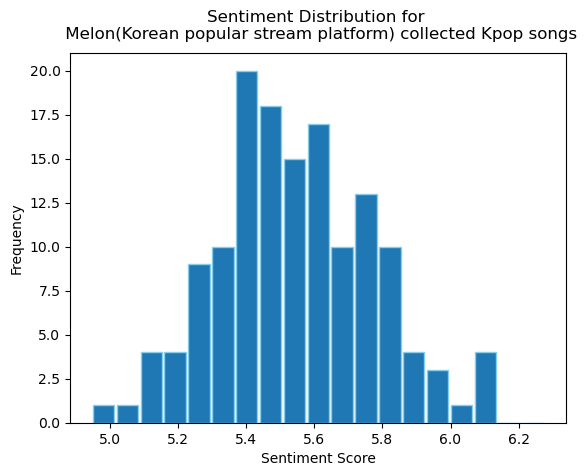

In [672]:
dist = dict(zip(list(MelonSongs_df.song.values), list(MelonSongs_df.Sentiment.values)))
v    = np.arange(min(MelonSongs_df.Sentiment), max(MelonSongs_df.Sentiment), step=.07)

# plotting
plt.hist(dist.values(), v, ec = 'skyblue', rwidth=.9)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution for \n Melon(Korean popular stream platform) collected Kpop songs', pad=10.0)
plt.show()